In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

# Load the dataset
df = pd.read_csv('performance.csv')

# Display basic info
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (2392, 15)

First 5 rows:


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [4]:
# Basic dataset information
print("Dataset Info:")
print(df.info())

print("\nStatistical Summary:")
df.describe()

# Check for missing values
print("\nMissing Values:")
df.isnull().sum()

# Check data types
print("\nData Types:")
df.dtypes

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB
None

Stat

StudentID              int64
Age                    int64
Gender                 int64
Ethnicity              int64
ParentalEducation      int64
StudyTimeWeekly      float64
Absences               int64
Tutoring               int64
ParentalSupport        int64
Extracurricular        int64
Sports                 int64
Music                  int64
Volunteering           int64
GPA                  float64
GradeClass           float64
dtype: object

In [5]:
# Create a copy for preprocessing
df_processed = df.copy()

# Map categorical variables for better interpretation
df_processed['Gender_Label'] = df_processed['Gender'].map({0: 'Male', 1: 'Female'})
df_processed['Ethnicity_Label'] = df_processed['Ethnicity'].map({0: 'Caucasian', 1: 'African American', 2: 'Asian', 3: 'Other'})
df_processed['ParentalEducation_Label'] = df_processed['ParentalEducation'].map({
    0: 'None', 1: 'High School', 2: 'Some College', 3: 'Bachelor', 4: 'Higher'
})

# Create GPA categories
def categorize_gpa(gpa):
    if gpa >= 3.5:
        return 'A (3.5-4.0)'
    elif gpa >= 3.0:
        return 'B (3.0-3.49)'
    elif gpa >= 2.0:
        return 'C (2.0-2.99)'
    elif gpa >= 1.0:
        return 'D (1.0-1.99)'
    else:
        return 'F (0-0.99)'

df_processed['GPACategory'] = df_processed['GPA'].apply(categorize_gpa)

# Create total activities feature
activity_columns = ['Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering']
df_processed['TotalActivities'] = df_processed[activity_columns].sum(axis=1)

print("Processed dataset shape:", df_processed.shape)
df_processed.head()

Processed dataset shape: (2392, 20)


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass,Gender_Label,Ethnicity_Label,ParentalEducation_Label,GPACategory,TotalActivities
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0,Female,Caucasian,Some College,C (2.0-2.99),2
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0,Male,Caucasian,High School,B (3.0-3.49),0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0,Male,Asian,Bachelor,F (0-0.99),0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0,Female,Caucasian,Bachelor,C (2.0-2.99),1
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0,Female,Caucasian,Some College,D (1.0-1.99),1


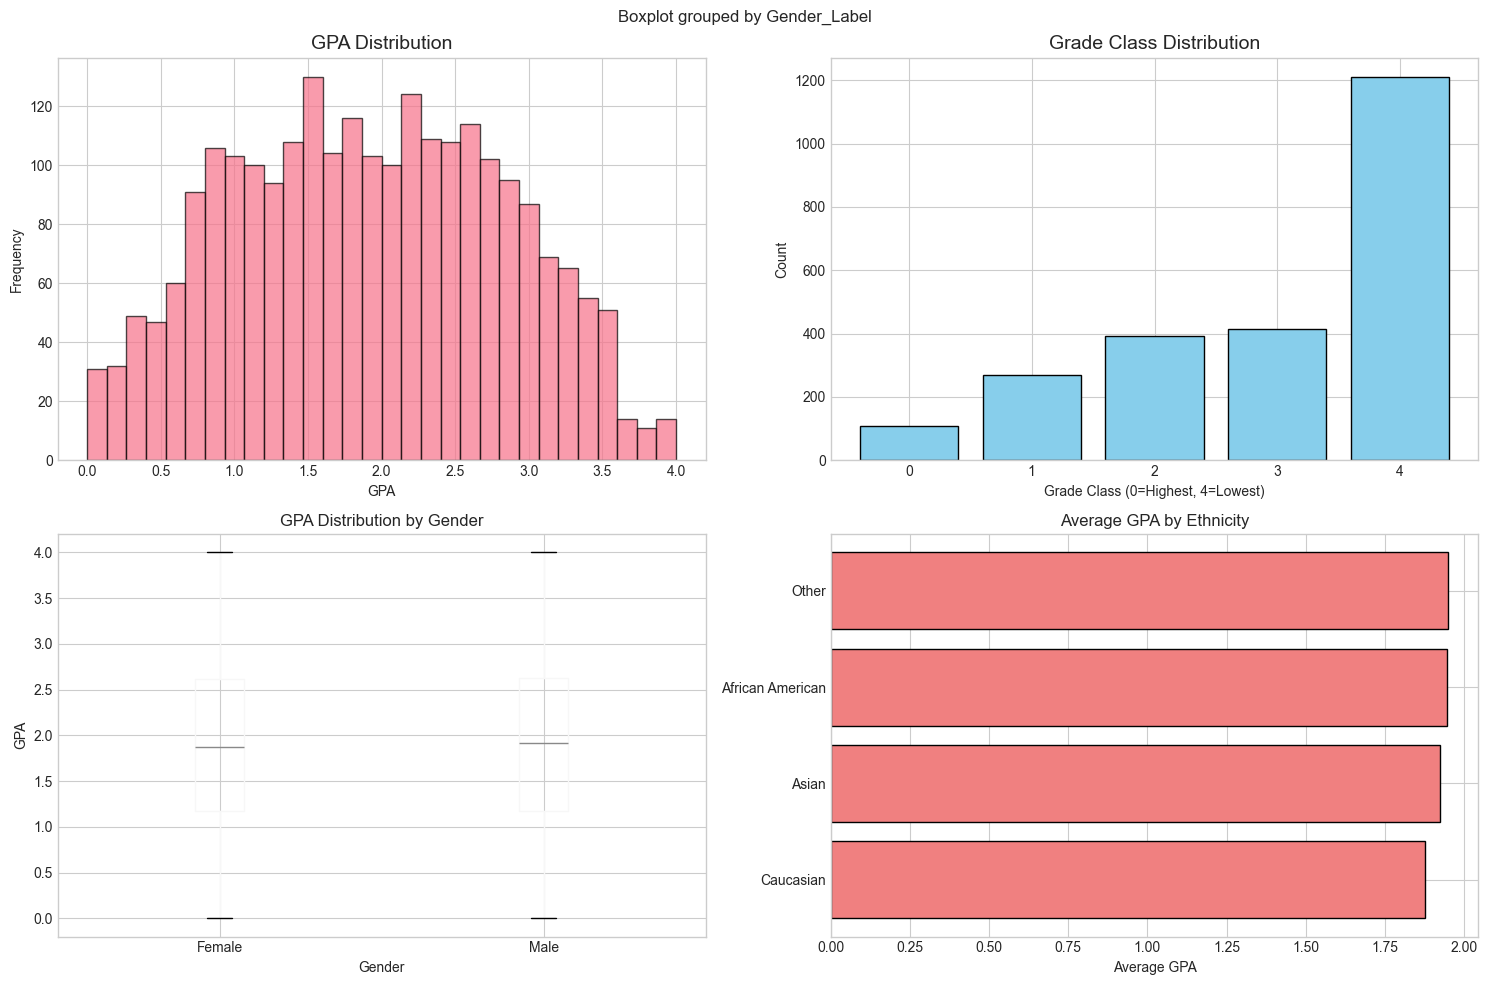

In [6]:
# 3.1 Distribution of Target Variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# GPA Distribution
axes[0,0].hist(df_processed['GPA'], bins=30, edgecolor='black', alpha=0.7)
axes[0,0].set_title('GPA Distribution', fontsize=14)
axes[0,0].set_xlabel('GPA')
axes[0,0].set_ylabel('Frequency')

# Grade Class Distribution
grade_counts = df_processed['GradeClass'].value_counts().sort_index()
axes[0,1].bar(grade_counts.index, grade_counts.values, color='skyblue', edgecolor='black')
axes[0,1].set_title('Grade Class Distribution', fontsize=14)
axes[0,1].set_xlabel('Grade Class (0=Highest, 4=Lowest)')
axes[0,1].set_ylabel('Count')

# GPA by Gender
df_processed.boxplot(column='GPA', by='Gender_Label', ax=axes[1,0])
axes[1,0].set_title('GPA Distribution by Gender')
axes[1,0].set_xlabel('Gender')
axes[1,0].set_ylabel('GPA')

# GPA by Ethnicity
ethnicity_gpa = df_processed.groupby('Ethnicity_Label')['GPA'].mean().sort_values()
axes[1,1].barh(ethnicity_gpa.index, ethnicity_gpa.values, color='lightcoral', edgecolor='black')
axes[1,1].set_title('Average GPA by Ethnicity')
axes[1,1].set_xlabel('Average GPA')

plt.tight_layout()
plt.show()

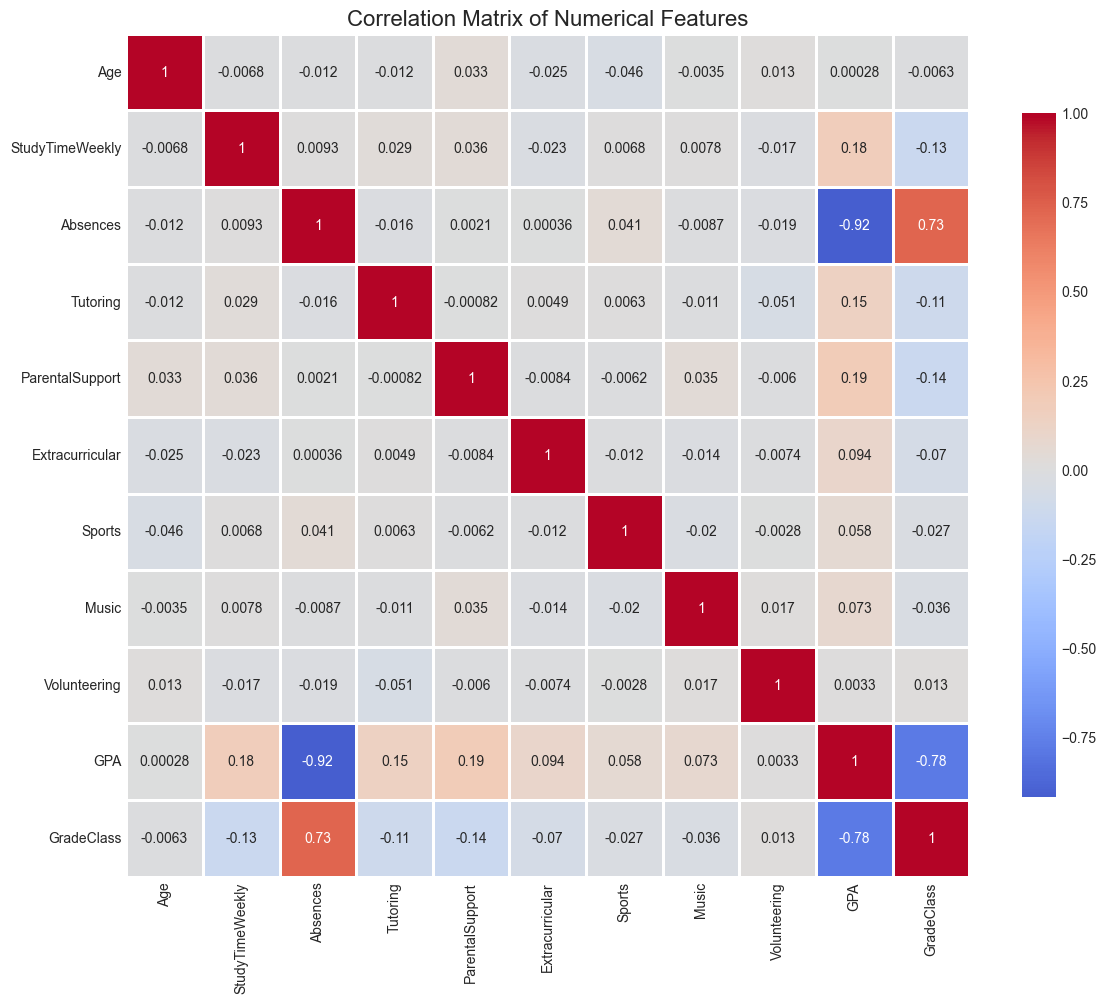

Top correlations with GPA:
GPA                1.000000
ParentalSupport    0.190774
StudyTimeWeekly    0.179275
Tutoring           0.145119
Extracurricular    0.094078
Music              0.073318
Sports             0.057859
Volunteering       0.003258
Age                0.000275
GradeClass        -0.782835
Absences          -0.919314
Name: GPA, dtype: float64


In [7]:
# 3.2 Correlation Analysis
# Select numerical features for correlation
numerical_features = ['Age', 'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 
                     'Extracurricular', 'Sports', 'Music', 'Volunteering', 'GPA', 'GradeClass']

plt.figure(figsize=(12, 10))
correlation_matrix = df_processed[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

# Top correlations with GPA
gpa_correlations = correlation_matrix['GPA'].sort_values(ascending=False)
print("Top correlations with GPA:")
print(gpa_correlations)

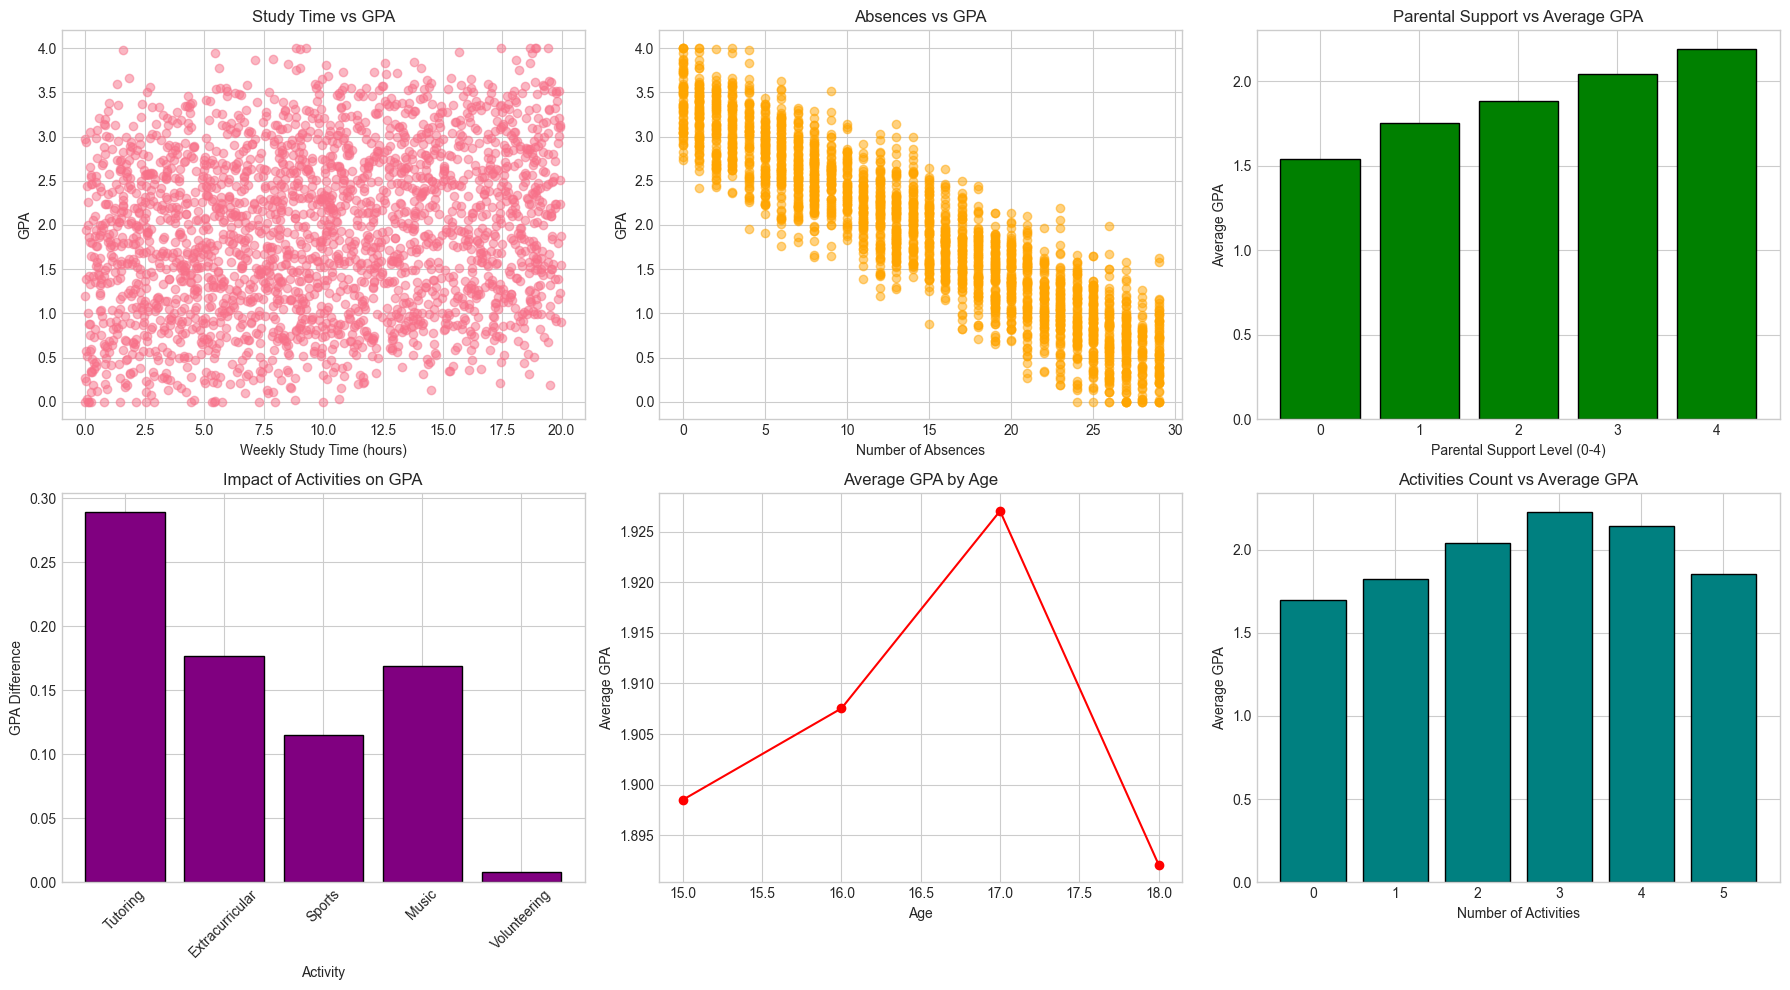

In [8]:
# 3.3 Analysis of Factors Affecting GPA

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Study Time vs GPA
axes[0,0].scatter(df_processed['StudyTimeWeekly'], df_processed['GPA'], alpha=0.5)
axes[0,0].set_xlabel('Weekly Study Time (hours)')
axes[0,0].set_ylabel('GPA')
axes[0,0].set_title('Study Time vs GPA')

# Absences vs GPA
axes[0,1].scatter(df_processed['Absences'], df_processed['GPA'], alpha=0.5, color='orange')
axes[0,1].set_xlabel('Number of Absences')
axes[0,1].set_ylabel('GPA')
axes[0,1].set_title('Absences vs GPA')

# Parental Support vs GPA
support_gpa = df_processed.groupby('ParentalSupport')['GPA'].mean()
axes[0,2].bar(range(len(support_gpa)), support_gpa.values, color='green', edgecolor='black')
axes[0,2].set_xlabel('Parental Support Level (0-4)')
axes[0,2].set_ylabel('Average GPA')
axes[0,2].set_title('Parental Support vs Average GPA')
axes[0,2].set_xticks(range(5))

# Activities Impact
activities = ['Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering']
activity_impact = []
for activity in activities:
    with_activity = df_processed[df_processed[activity] == 1]['GPA'].mean()
    without_activity = df_processed[df_processed[activity] == 0]['GPA'].mean()
    activity_impact.append(with_activity - without_activity)

axes[1,0].bar(activities, activity_impact, color='purple', edgecolor='black')
axes[1,0].set_xlabel('Activity')
axes[1,0].set_ylabel('GPA Difference')
axes[1,0].set_title('Impact of Activities on GPA')
axes[1,0].tick_params(axis='x', rotation=45)

# Age vs GPA
age_gpa = df_processed.groupby('Age')['GPA'].mean()
axes[1,1].plot(age_gpa.index, age_gpa.values, marker='o', linestyle='-', color='red')
axes[1,1].set_xlabel('Age')
axes[1,1].set_ylabel('Average GPA')
axes[1,1].set_title('Average GPA by Age')

# Total Activities vs GPA
activity_groups = df_processed.groupby('TotalActivities')['GPA'].agg(['mean', 'count']).reset_index()
axes[1,2].bar(activity_groups['TotalActivities'], activity_groups['mean'], color='teal', edgecolor='black')
axes[1,2].set_xlabel('Number of Activities')
axes[1,2].set_ylabel('Average GPA')
axes[1,2].set_title('Activities Count vs Average GPA')

plt.tight_layout()
plt.show()

GPA by Parental Education Level:
                         mean  count   std
ParentalEducation_Label                   
Bachelor                 1.81    367  0.94
High School              1.94    728  0.90
Higher                   1.82    120  0.81
None                     1.89    243  0.90
Some College             1.93    934  0.93


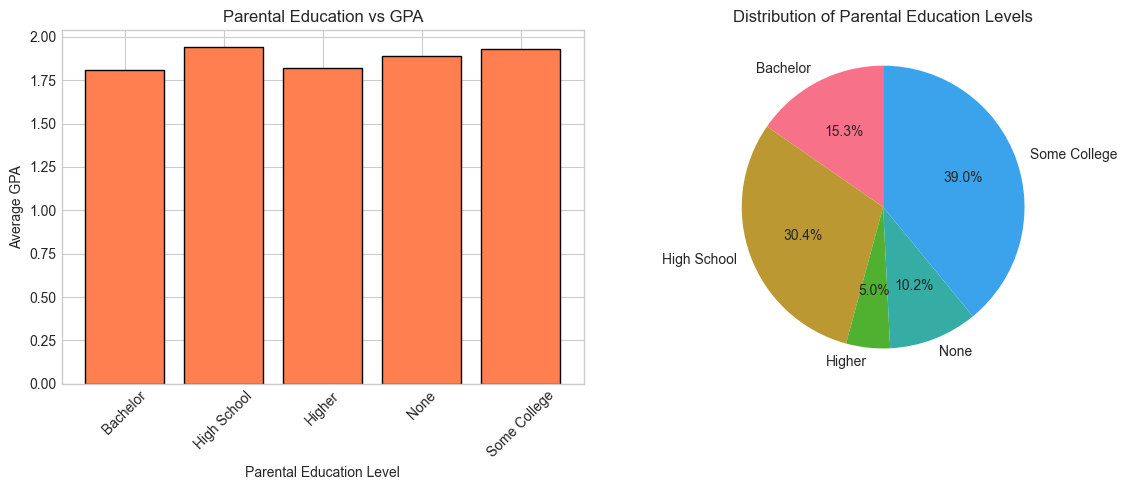

In [9]:
# 3.4 Parental Education Analysis
parental_edu_gpa = df_processed.groupby('ParentalEducation_Label')['GPA'].agg(['mean', 'count', 'std']).round(2)
print("GPA by Parental Education Level:")
print(parental_edu_gpa)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
edu_order = parental_edu_gpa.index
edu_gpa_values = [parental_edu_gpa.loc[edu, 'mean'] for edu in edu_order]
plt.bar(range(len(edu_order)), edu_gpa_values, color='coral', edgecolor='black')
plt.xticks(range(len(edu_order)), edu_order, rotation=45)
plt.xlabel('Parental Education Level')
plt.ylabel('Average GPA')
plt.title('Parental Education vs GPA')

plt.subplot(1, 2, 2)
edu_counts = parental_edu_gpa['count']
plt.pie(edu_counts, labels=edu_order, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Parental Education Levels')

plt.tight_layout()
plt.show()

In [10]:
# Prepare data for classification
# Features for prediction
feature_columns = ['Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 
                   'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular', 
                   'Sports', 'Music', 'Volunteering']

X = df_processed[feature_columns]
y = df_processed['GradeClass']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (1913, 12)
Test set size: (479, 12)


Random Forest Classifier Results:
Accuracy: 0.7098

Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.14      0.23        21
         1.0       0.58      0.52      0.55        54
         2.0       0.52      0.67      0.58        78
         3.0       0.46      0.45      0.45        83
         4.0       0.90      0.91      0.90       243

    accuracy                           0.71       479
   macro avg       0.61      0.54      0.54       479
weighted avg       0.71      0.71      0.70       479



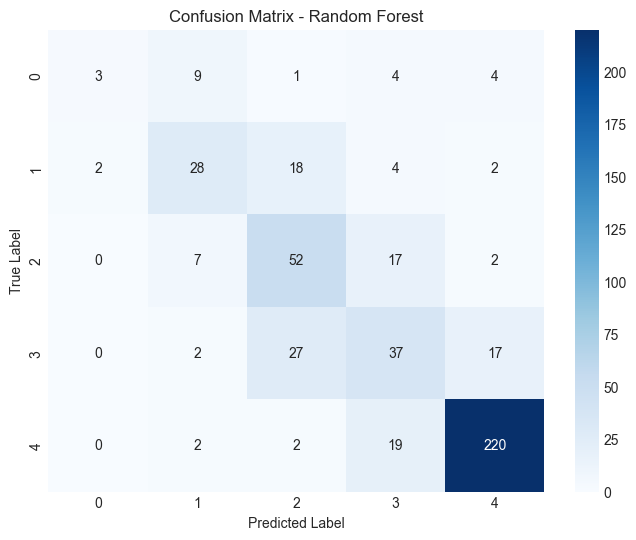

In [11]:
# 4.1 Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_classifier.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_classifier.predict(X_test_scaled)

# Evaluation
print("Random Forest Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

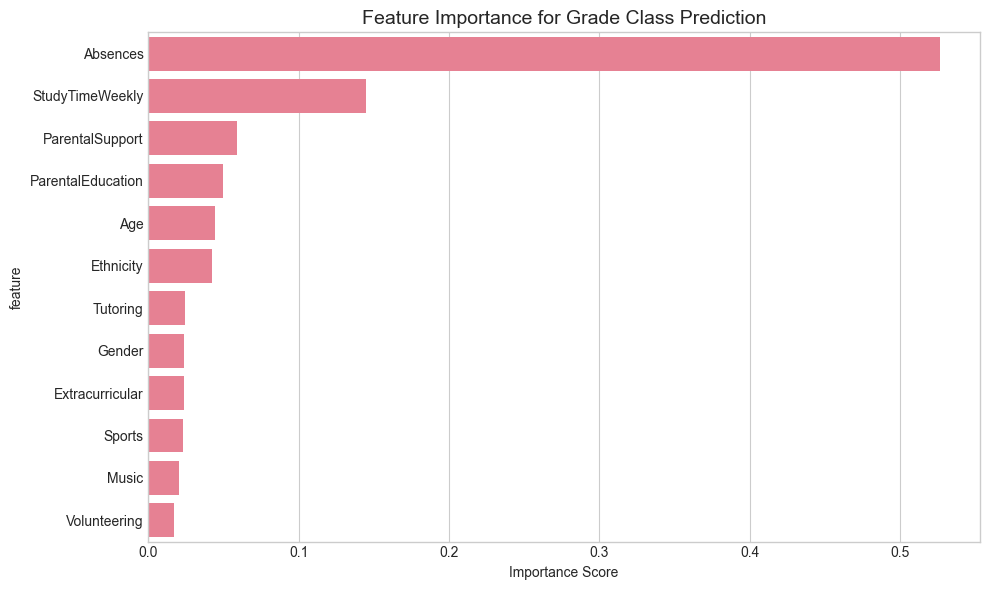

Top 5 Most Important Features:
             feature  importance
5           Absences    0.526865
4    StudyTimeWeekly    0.145125
7    ParentalSupport    0.058932
3  ParentalEducation    0.049430
0                Age    0.044689


In [13]:
# 4.2 Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Grade Class Prediction', fontsize=14)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("Top 5 Most Important Features:")
print(feature_importance.head())

Decision Tree Classifier Results:
Accuracy: 0.6910

Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.14      0.23        21
         1.0       0.55      0.52      0.53        54
         2.0       0.48      0.62      0.54        78
         3.0       0.43      0.43      0.43        83
         4.0       0.91      0.89      0.90       243

    accuracy                           0.69       479
   macro avg       0.59      0.52      0.53       479
weighted avg       0.70      0.69      0.69       479



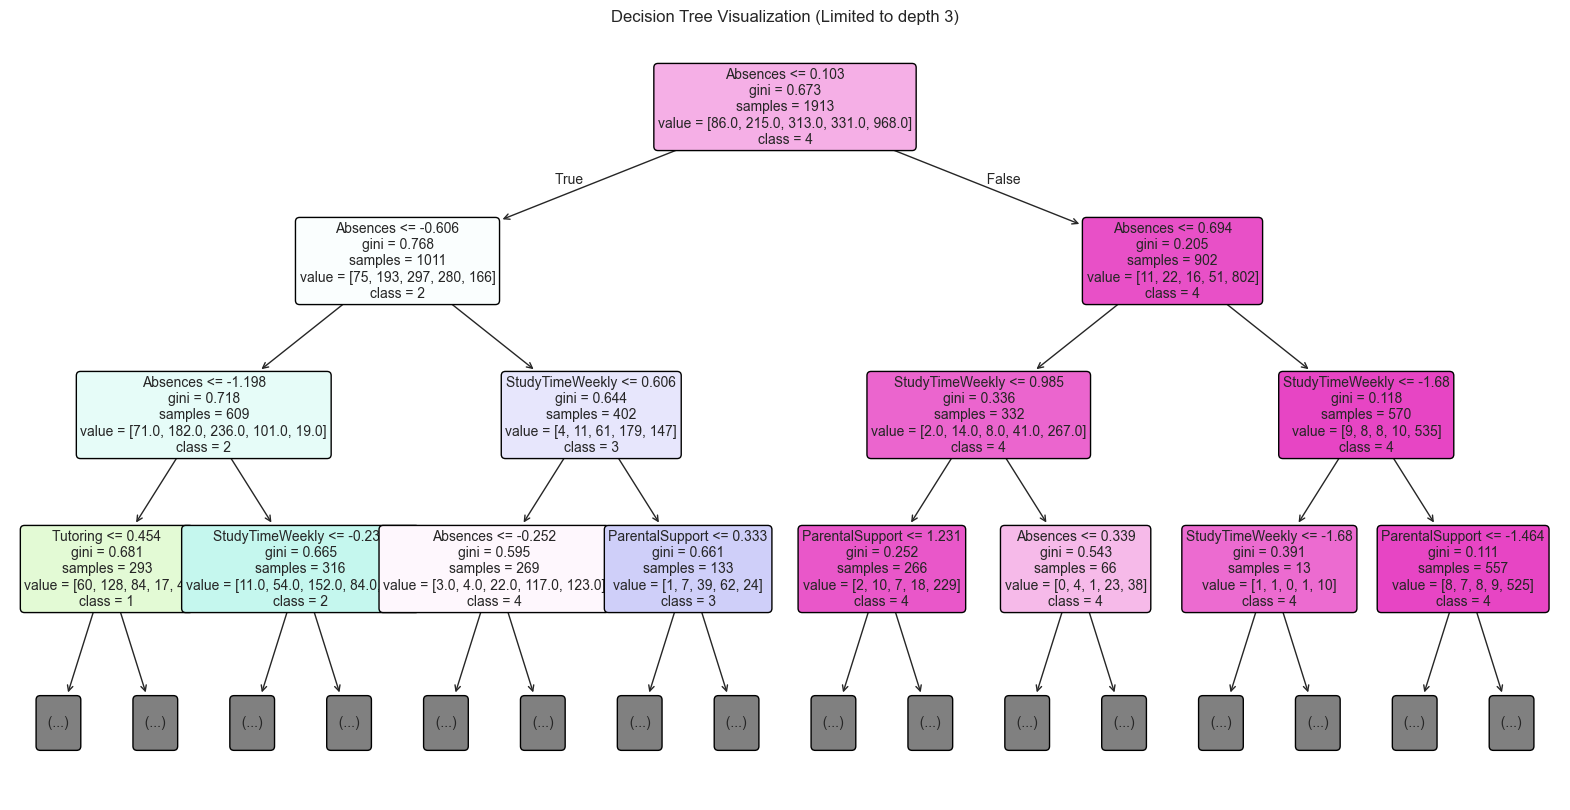

In [14]:
# 4.3 Decision Tree Classifier (for interpretability)
dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_classifier.fit(X_train_scaled, y_train)

# Predictions
y_pred_dt = dt_classifier.predict(X_test_scaled)

# Evaluation
print("Decision Tree Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

# Visualize the decision tree (simplified)
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, feature_names=feature_columns, class_names=['0', '1', '2', '3', '4'], 
          filled=True, rounded=True, max_depth=3, fontsize=10)
plt.title('Decision Tree Visualization (Limited to depth 3)')
plt.show()

In [15]:
# Prepare data for regression
y_gpa = df_processed['GPA']

# Split the data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_gpa, test_size=0.2, random_state=42
)

# Scale the features
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

print("Regression Analysis - Predicting GPA")

Regression Analysis - Predicting GPA


In [16]:
# 5.1 Multiple Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_reg_scaled, y_train_reg)

# Predictions
y_pred_lr = lr_model.predict(X_test_reg_scaled)

# Evaluation
print("Linear Regression Results:")
print(f"R² Score: {r2_score(y_test_reg, y_pred_lr):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_lr)):.4f}")

# Coefficients
coefficients = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': lr_model.coef_
}).sort_values('coefficient', ascending=False)

print("\nTop Positive Influencers on GPA:")
print(coefficients.head())
print("\nTop Negative Influencers on GPA:")
print(coefficients.tail())

Linear Regression Results:
R² Score: 0.9532
RMSE: 0.1966

Top Positive Influencers on GPA:
           feature  coefficient
4  StudyTimeWeekly     0.165558
7  ParentalSupport     0.165286
6         Tutoring     0.118590
8  Extracurricular     0.092005
9           Sports     0.085152

Top Negative Influencers on GPA:
              feature  coefficient
2           Ethnicity     0.004895
3   ParentalEducation     0.000124
11       Volunteering    -0.001918
0                 Age    -0.006448
5            Absences    -0.844216


Random Forest Regressor Results:
R² Score: 0.9265
RMSE: 0.2465

Feature Importance for GPA Prediction:
              feature  importance
5            Absences    0.862025
4     StudyTimeWeekly    0.055603
7     ParentalSupport    0.031481
6            Tutoring    0.014434
8     Extracurricular    0.007519
9              Sports    0.006889
0                 Age    0.005179
3   ParentalEducation    0.005075
2           Ethnicity    0.004470
10              Music    0.003696
1              Gender    0.001936
11       Volunteering    0.001692


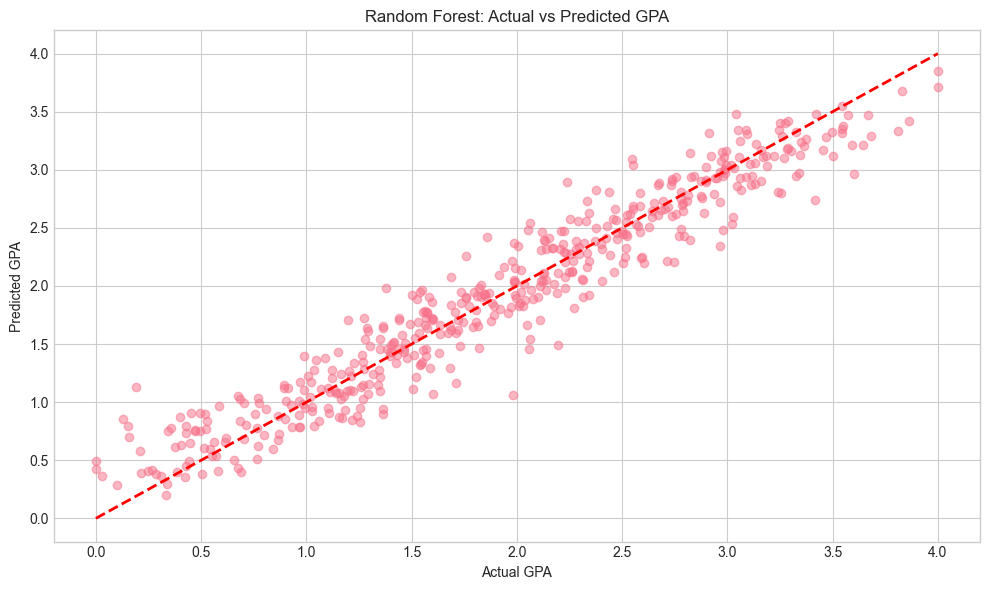

In [17]:
# 5.2 Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_regressor.fit(X_train_reg_scaled, y_train_reg)

# Predictions
y_pred_rf_reg = rf_regressor.predict(X_test_reg_scaled)

# Evaluation
print("Random Forest Regressor Results:")
print(f"R² Score: {r2_score(y_test_reg, y_pred_rf_reg):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_rf_reg)):.4f}")

# Feature importance for regression
rf_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_regressor.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance for GPA Prediction:")
print(rf_importance)

# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_rf_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual GPA')
plt.ylabel('Predicted GPA')
plt.title('Random Forest: Actual vs Predicted GPA')
plt.tight_layout()
plt.show()

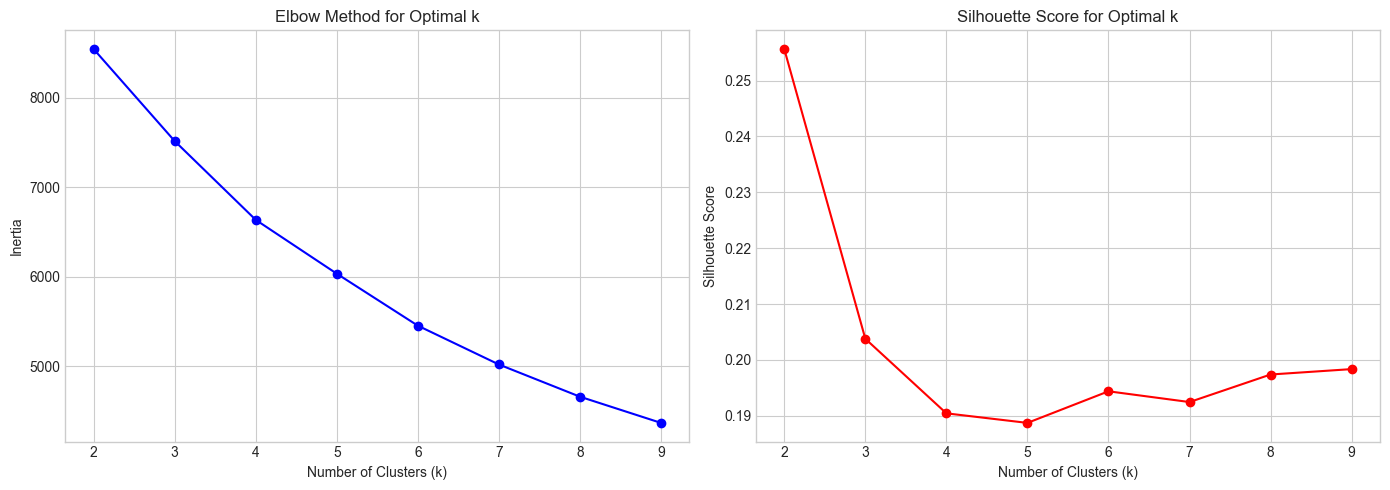

In [18]:
# Select features for clustering
cluster_features = ['StudyTimeWeekly', 'Absences', 'GPA', 'ParentalSupport', 'TotalActivities']
X_cluster = df_processed[cluster_features].copy()

# Standardize features
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# Find optimal number of clusters using Elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    
    from sklearn.metrics import silhouette_score
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

# Plot Elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score for Optimal k')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [19]:
# Apply K-Means with optimal k (let's choose k=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_processed['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Analyze clusters
cluster_analysis = df_processed.groupby('Cluster')[cluster_features].mean()
cluster_analysis['Count'] = df_processed.groupby('Cluster').size()

print("Cluster Analysis:")
print(cluster_analysis.round(2))

# Cluster profiles
print("\nCluster Profiles:")
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    print(f"  Size: {cluster_analysis.loc[i, 'Count']} students ({cluster_analysis.loc[i, 'Count']/len(df_processed)*100:.1f}%)")
    print(f"  Avg Study Time: {cluster_analysis.loc[i, 'StudyTimeWeekly']:.2f} hours")
    print(f"  Avg Absences: {cluster_analysis.loc[i, 'Absences']:.2f}")
    print(f"  Avg GPA: {cluster_analysis.loc[i, 'GPA']:.2f}")
    print(f"  Avg Parental Support: {cluster_analysis.loc[i, 'ParentalSupport']:.2f}")
    print(f"  Avg Activities: {cluster_analysis.loc[i, 'TotalActivities']:.2f}")

Cluster Analysis:
         StudyTimeWeekly  Absences   GPA  ParentalSupport  TotalActivities  \
Cluster                                                                      
0                   9.80      8.15  2.75             2.19             2.39   
1                   5.22     21.13  1.02             1.79             1.17   
2                  15.06     21.94  1.35             2.35             1.38   
3                   9.98      6.80  2.59             2.22             0.63   

         Count  
Cluster         
0          532  
1          666  
2          545  
3          649  

Cluster Profiles:

Cluster 0:
  Size: 532 students (22.2%)
  Avg Study Time: 9.80 hours
  Avg Absences: 8.15
  Avg GPA: 2.75
  Avg Parental Support: 2.19
  Avg Activities: 2.39

Cluster 1:
  Size: 666 students (27.8%)
  Avg Study Time: 5.22 hours
  Avg Absences: 21.13
  Avg GPA: 1.02
  Avg Parental Support: 1.79
  Avg Activities: 1.17

Cluster 2:
  Size: 545 students (22.8%)
  Avg Study Time: 15.06 hours
  

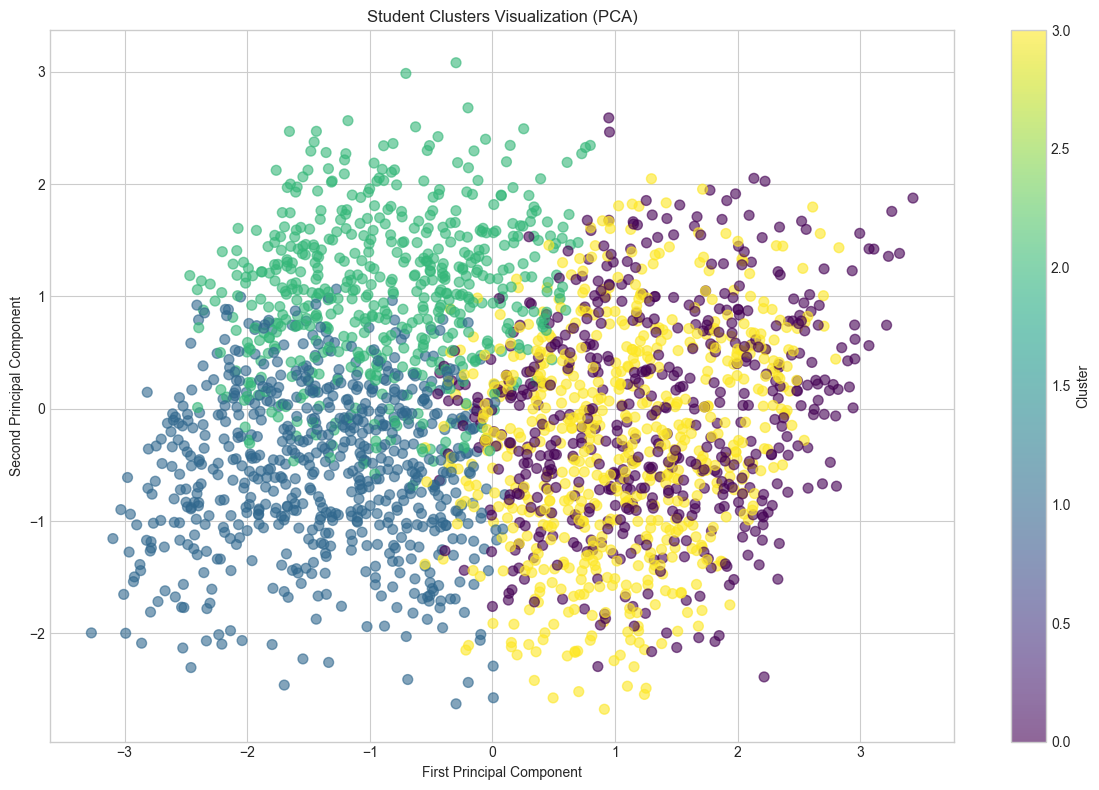

Explained variance ratio: [0.39425888 0.20760378]


In [20]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_processed['Cluster'], 
                      cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Student Clusters Visualization (PCA)')
plt.tight_layout()
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Risk Factor Analysis:
                   Not At Risk  At Risk  Difference
StudyTimeWeekly         10.494    9.139      -1.355
ParentalSupport          2.253    2.007      -0.246
TotalActivities          1.428    1.268      -0.160
Tutoring                 0.336    0.271      -0.066
Ethnicity                0.912    0.847      -0.065
Extracurricular          0.412    0.358      -0.054
Sports                   0.317    0.292      -0.025
Music                    0.209    0.186      -0.023
Volunteering             0.153    0.161       0.008
Age                     16.462   16.474       0.012
Gender                   0.504    0.517       0.014
ParentalEducation        1.716    1.772       0.056
Absences                 7.191   20.992      13.802


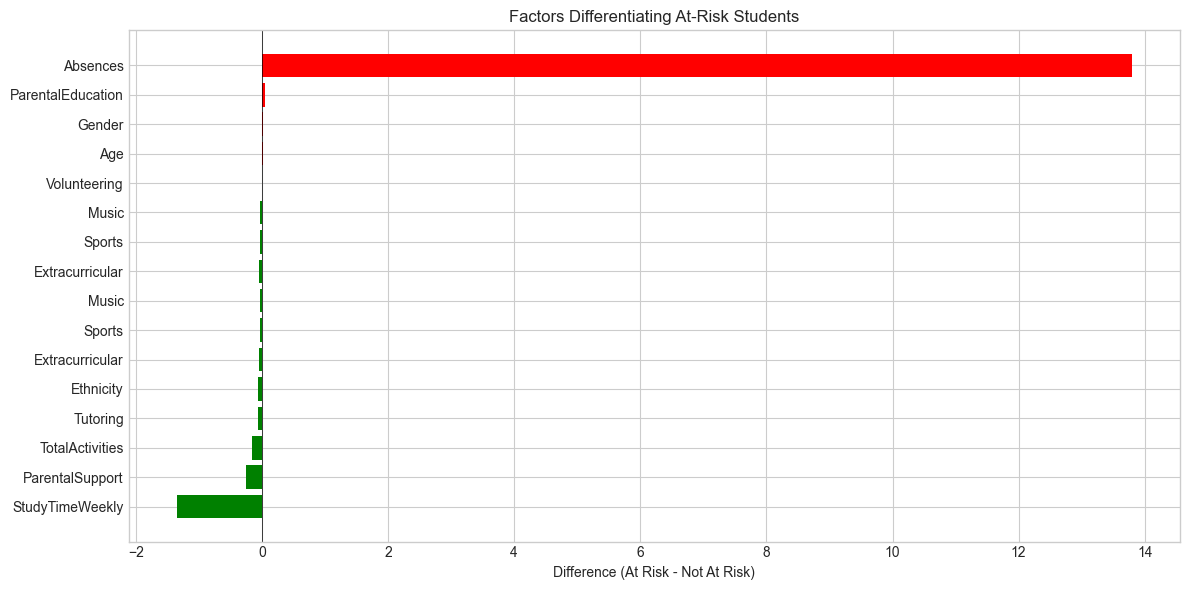

In [21]:
# Define at-risk students (GPA < 2.0)
df_processed['AtRisk'] = (df_processed['GPA'] < 2.0).astype(int)

# Analyze risk factors
risk_features = ['Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 
                 'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular', 
                 'Sports', 'Music', 'Volunteering', 'TotalActivities']

# Compare at-risk vs not at-risk
risk_comparison = df_processed.groupby('AtRisk')[risk_features].mean().T
risk_comparison.columns = ['Not At Risk', 'At Risk']
risk_comparison['Difference'] = risk_comparison['At Risk'] - risk_comparison['Not At Risk']
risk_comparison = risk_comparison.sort_values('Difference')

print("Risk Factor Analysis:")
print(risk_comparison.round(3))

# Visualize key differences
plt.figure(figsize=(12, 6))
top_factors = risk_comparison.head(8)
bottom_factors = risk_comparison.tail(8)
key_factors = pd.concat([top_factors, bottom_factors])

x = range(len(key_factors))
plt.barh(x, key_factors['Difference'], color=['red' if d > 0 else 'green' for d in key_factors['Difference']])
plt.yticks(x, key_factors.index)
plt.xlabel('Difference (At Risk - Not At Risk)')
plt.title('Factors Differentiating At-Risk Students')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

In [22]:
# Create a comprehensive summary
print("="*60)
print("STUDENT PERFORMANCE ANALYSIS - SUMMARY REPORT")
print("="*60)

print("\n1. DATASET OVERVIEW:")
print(f"   - Total Students: {len(df_processed)}")
print(f"   - Age Range: {df_processed['Age'].min()} - {df_processed['Age'].max()} years")
print(f"   - Average GPA: {df_processed['GPA'].mean():.3f}")
print(f"   - GPA Range: {df_processed['GPA'].min():.3f} - {df_processed['GPA'].max():.3f}")

print("\n2. KEY FACTORS AFFECTING GPA:")
print("   Positive Factors:")
positive_factors = feature_importance.head(5)
for idx, row in positive_factors.iterrows():
    print(f"   - {row['feature']}: {row['importance']:.4f} importance")

print("\n   Negative Factors:")
negative_factors = feature_importance.tail(5)
for idx, row in negative_factors.iterrows():
    print(f"   - {row['feature']}: {row['importance']:.4f} importance")

print("\n3. RISK FACTORS (Students with GPA < 2.0):")
risk_summary = risk_comparison['Difference'].sort_values()
print(f"   - At-Risk Students: {df_processed['AtRisk'].sum()} ({df_processed['AtRisk'].mean()*100:.1f}%)")
print("   - Key Risk Indicators:")
for factor in risk_summary.head(3).index:
    print(f"     * Higher {factor}: +{risk_summary[factor]:.3f}")
for factor in risk_summary.tail(3).index:
    print(f"     * Lower {factor}: {risk_summary[factor]:.3f}")

print("\n4. STUDENT CLUSTERS:")
for i in range(optimal_k):
    cluster_size = cluster_analysis.loc[i, 'Count']
    cluster_gpa = cluster_analysis.loc[i, 'GPA']
    print(f"   Cluster {i}: {cluster_size} students (Avg GPA: {cluster_gpa:.2f})")

print("\n5. MODEL PERFORMANCE:")
print(f"   - Classification Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"   - GPA Prediction R² Score: {r2_score(y_test_reg, y_pred_rf_reg):.4f}")
print(f"   - GPA Prediction RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_rf_reg)):.4f}")

print("\n" + "="*60)
print("RECOMMENDATIONS:")
print("="*60)
print("""
1. Early Intervention: Focus on students with high absences and low study time
2. Activity Programs: Encourage participation in tutoring and extracurriculars
3. Parental Engagement: Increase parental support, especially for at-risk students
4. Study Skills Workshops: Implement programs to improve study time efficiency
5. Absence Monitoring: Track and address chronic absenteeism
""")

STUDENT PERFORMANCE ANALYSIS - SUMMARY REPORT

1. DATASET OVERVIEW:
   - Total Students: 2392
   - Age Range: 15 - 18 years
   - Average GPA: 1.906
   - GPA Range: 0.000 - 4.000

2. KEY FACTORS AFFECTING GPA:
   Positive Factors:
   - Absences: 0.5269 importance
   - StudyTimeWeekly: 0.1451 importance
   - ParentalSupport: 0.0589 importance
   - ParentalEducation: 0.0494 importance
   - Age: 0.0447 importance

   Negative Factors:
   - Gender: 0.0239 importance
   - Extracurricular: 0.0236 importance
   - Sports: 0.0233 importance
   - Music: 0.0201 importance
   - Volunteering: 0.0172 importance

3. RISK FACTORS (Students with GPA < 2.0):
   - At-Risk Students: 1274 (53.3%)
   - Key Risk Indicators:
     * Higher StudyTimeWeekly: +-1.355
     * Higher ParentalSupport: +-0.246
     * Higher TotalActivities: +-0.160
     * Lower Gender: 0.014
     * Lower ParentalEducation: 0.056
     * Lower Absences: 13.802

4. STUDENT CLUSTERS:
   Cluster 0: 532 students (Avg GPA: 2.75)
   Cluster 1:

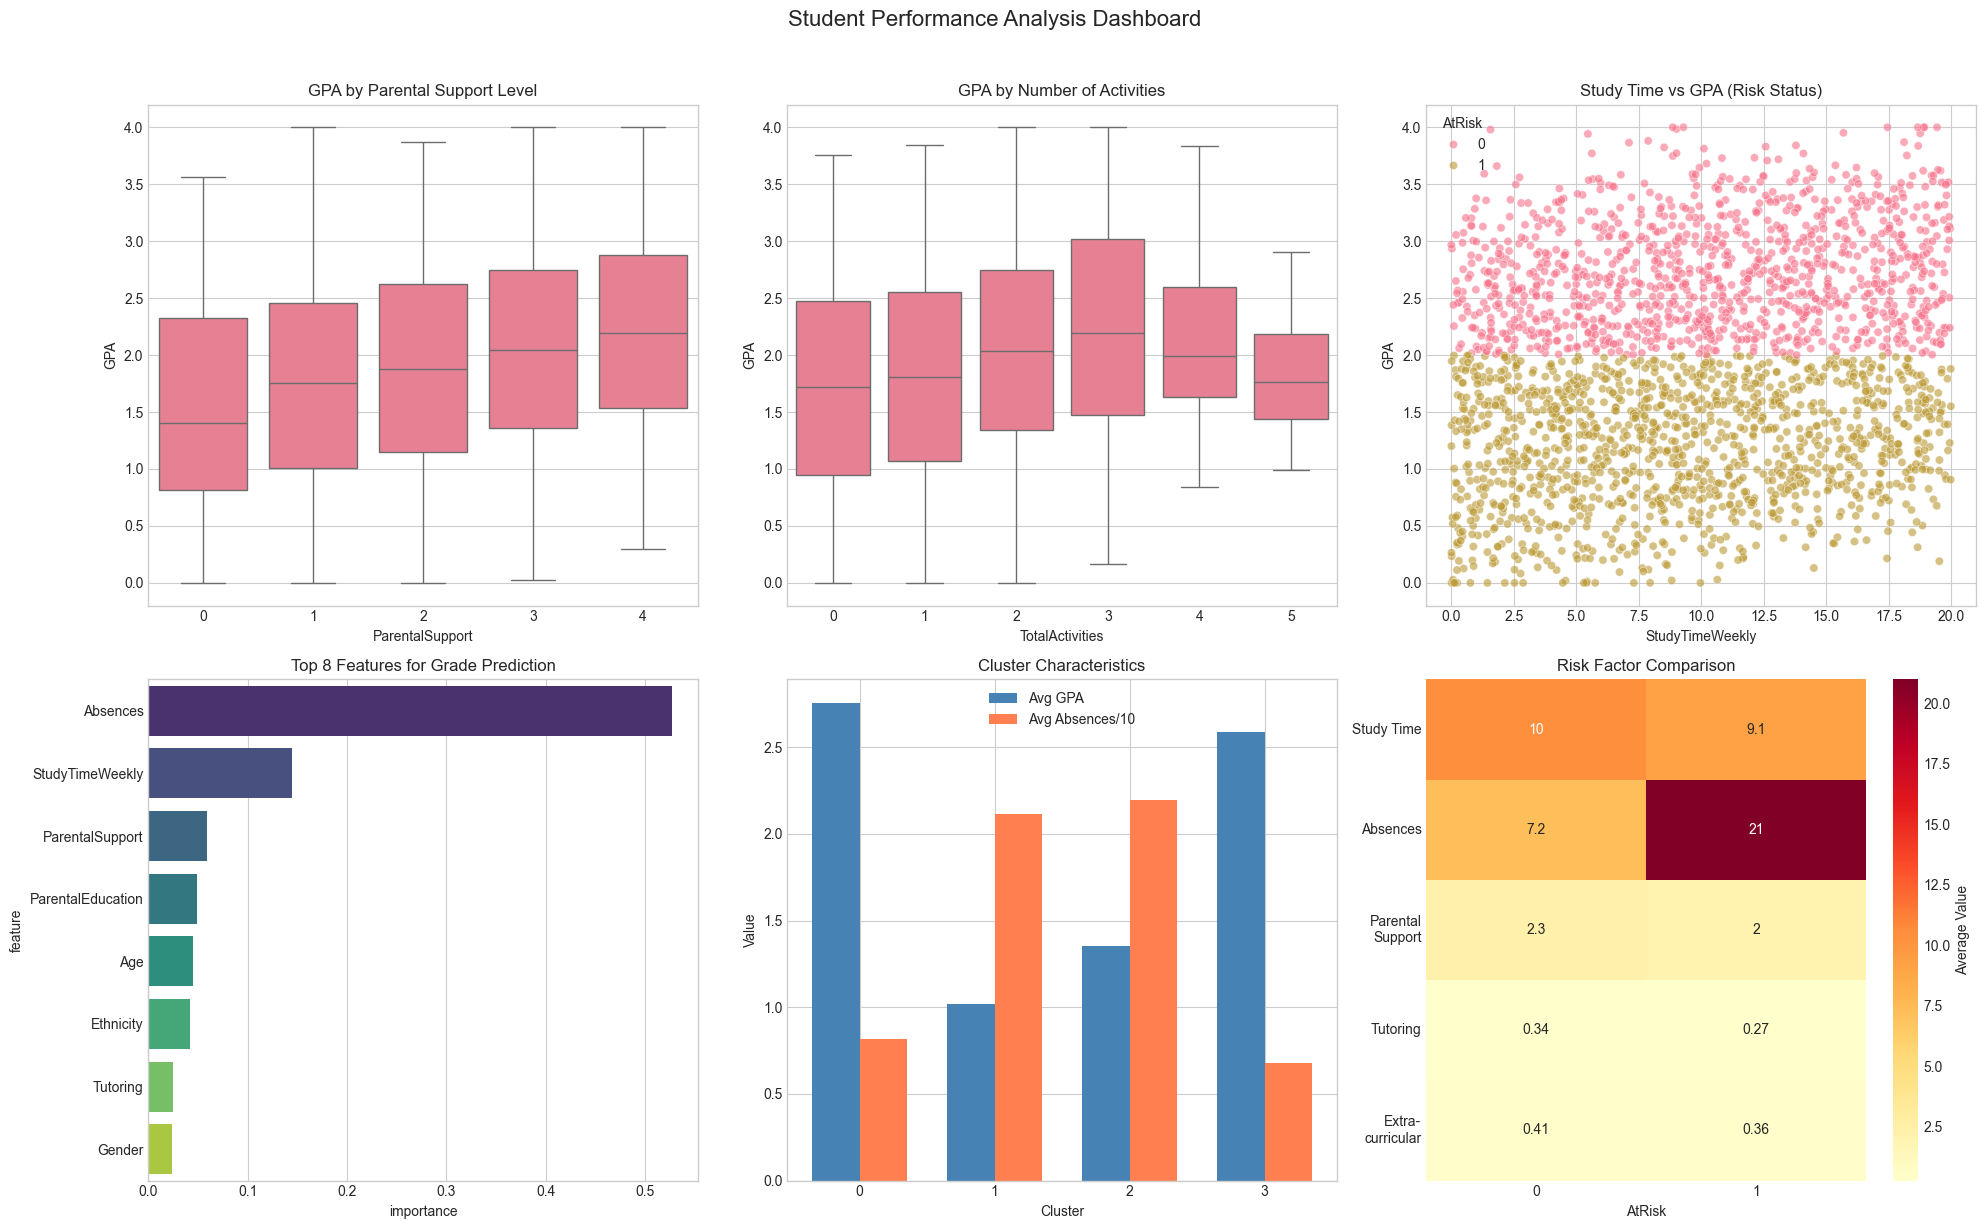

In [23]:
# Final visualization - Comprehensive dashboard
fig = plt.figure(figsize=(20, 12))

# 1. GPA Distribution by Key Factors
ax1 = plt.subplot(2, 3, 1)
sns.boxplot(x='ParentalSupport', y='GPA', data=df_processed)
ax1.set_title('GPA by Parental Support Level')

ax2 = plt.subplot(2, 3, 2)
sns.boxplot(x='TotalActivities', y='GPA', data=df_processed)
ax2.set_title('GPA by Number of Activities')

ax3 = plt.subplot(2, 3, 3)
sns.scatterplot(x='StudyTimeWeekly', y='GPA', hue='AtRisk', data=df_processed, alpha=0.6)
ax3.set_title('Study Time vs GPA (Risk Status)')

# 2. Feature Importance
ax4 = plt.subplot(2, 3, 4)
top_features = feature_importance.head(8)
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
ax4.set_title('Top 8 Features for Grade Prediction')

# 3. Cluster Characteristics
ax5 = plt.subplot(2, 3, 5)
cluster_gpa = df_processed.groupby('Cluster')['GPA'].mean()
cluster_absent = df_processed.groupby('Cluster')['Absences'].mean()
x = np.arange(len(cluster_gpa))
width = 0.35
ax5.bar(x - width/2, cluster_gpa, width, label='Avg GPA', color='steelblue')
ax5.bar(x + width/2, cluster_absent/10, width, label='Avg Absences/10', color='coral')
ax5.set_xlabel('Cluster')
ax5.set_ylabel('Value')
ax5.set_title('Cluster Characteristics')
ax5.set_xticks(x)
ax5.legend()

# 4. Risk Factor Heatmap
ax6 = plt.subplot(2, 3, 6)
risk_matrix = df_processed.groupby('AtRisk')[['StudyTimeWeekly', 'Absences', 'ParentalSupport', 
                                               'Tutoring', 'Extracurricular']].mean()
sns.heatmap(risk_matrix.T, annot=True, cmap='YlOrRd', cbar_kws={'label': 'Average Value'}, ax=ax6)
ax6.set_title('Risk Factor Comparison')
ax6.set_yticklabels(['Study Time', 'Absences', 'Parental\nSupport', 'Tutoring', 'Extra-\ncurricular'])

plt.suptitle('Student Performance Analysis Dashboard', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [24]:
# Export processed data and results
df_processed.to_csv('student_performance_processed.csv', index=False)

# Save cluster assignments
cluster_summary = df_processed.groupby('Cluster').agg({
    'StudentID': 'count',
    'GPA': ['mean', 'min', 'max'],
    'StudyTimeWeekly': 'mean',
    'Absences': 'mean',
    'ParentalSupport': 'mean',
    'TotalActivities': 'mean'
}).round(2)
cluster_summary.to_csv('cluster_analysis.csv')

print("Processed data and cluster analysis saved to CSV files.")

Processed data and cluster analysis saved to CSV files.
